In [62]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing

In [63]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.0,1.0])
    plt.xlim([xleft, xright])
    #plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [64]:
n_features = 100
X, y = make_classification(n_clusters_per_class = 1, n_classes=10, n_samples = 4000, n_features = n_features, n_informative = 20, random_state=8, flip_y= 0.01)
X_train, X_test = np.split(X, [1000])
y_train, y_test = np.split(y, [1000])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [65]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

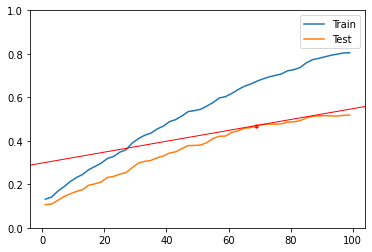

AT (69, 0.47043333333333337, 0.5616533333333333) WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:08.148593400


In [66]:
RANDOM_SELECTION()
#RANDOM_SELECTION(kernel='linear')

#data.kernel_matrix = 'poly'
#RANDOM_SELECTION(kernel='precomputed')

#data.kernel_matrix = None
#RANDOM_SELECTION(kernel='poly')

# SVM

In [89]:
@time_func
def SVM_RFE(step, C = 0.5, w1 = [0.8, 0.2]):
    data.kernel = 'liblinear'
    data.kernel_matrix = 'linear'
    data.C = C
    data.degree = 1
    kf = KFold(n_splits=18, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_multi, index)

    #scores = list(map(data.svm_rfe_multi, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time

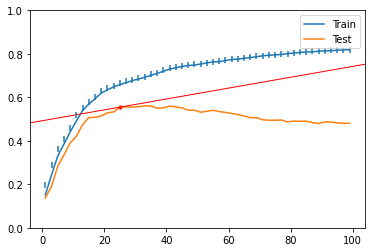

AT (25, 0.5548881673881674, 0.4060894660894661) WITH 50 ITERATIONS IN 2.856186125013563 SECONDS : 0.06315663523122268
__main__.SVM_RFE - 00:00:19.754051100


((25, 0.5548881673881674, 0.4060894660894661), 2.856186125013563)

In [90]:
SVM_RFE(2)